In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal

In [2]:
path = "./data.csv"

In [3]:
df = pd.read_csv(path)

In [5]:
display(df)

,Unnamed: 0,Time,C3,C4,L_neck_emg,R_neck_emg
0,0,0.000000,1.373078e-06,-1.449991e-07,-0.000004,-0.000003
1,1,0.003906,3.093208e-08,-1.129674e-06,-0.000005,-0.000003
2,2,0.007812,-1.830364e-06,-5.016436e-06,0.000006,0.000015
3,3,0.011719,-2.142743e-06,-3.918224e-06,0.000028,0.000024
4,4,0.015625,-6.168474e-08,-1.134132e-06,0.000011,0.000033
...,...,...,...,...,...,...
158831,158831,620.433594,-2.813751e-06,-2.180171e-06,-0.000004,-0.000005
158832,158832,620.437500,2.358402e-06,4.081944e-06,0.000015,-0.000003
158833,158833,620.441406,4.989488e-06,3.924692e-06,0.000006,-0.000010
158834,158834,620.445312,2.356918e-06,1.135322e-06,-0.000002,0.000003


In [7]:
timestamp = df["Time"].copy()
timestamp_diff = 1/timestamp.diff()
fs = timestamp_diff.mean()
print(fs)

256.0


In [32]:
class PowerSpectra():
    def __init__(self, eeg_df, fs, target_ch=["C3","C4"], nperseg=128, noverlap=32, nperseg2nd=128, noverlap2nd=32):
        # 帯域の定義
        self.BAND_DEF = {}
        self.BAND_DEF["delta"] = (0.5, 3)
        self.BAND_DEF["theta"] = (4, 8)
        self.BAND_DEF["alpha"] = (8, 15)   
        self.BAND_DEF["beta"] = (15, 30)   
        self.BAND_DEF["gamma"] = (30, 80)   
        
        # チャンネルごとにパワースペクトルを計算
        self.src_df = eeg_df
        self.fs = fs
        self.target_ch = target_ch     
        self.psd_dict, self.psd_dfs = self.__get_psd_dfs(self.src_df, self.target_ch, nperseg, noverlap)
        
        # チャンネルごとにバンド別のパワースペクトルを計算(積分)
        self.psd_bb_dfs = self.__get_psd_by_band(self.psd_dfs)

    def __get_psd_dfs(self, src_df, targets, nperseg, noverlap):
        ret_dict = {}
        ret_dfs = {}
        for target in targets:
            print(target)
            data = src_df[target]
            #display(data)
            frq, t, Pxx = signal.stft(data, fs=self.fs, nperseg=nperseg, noverlap=noverlap)
            Pxx = np.abs(Pxx)
            
            ret_dict[target] = (frq, t, Pxx)
            ret_dfs[target] = self.__psd2df(frq, t, Pxx)
            
        return ret_dict, ret_dfs
        
    def __get_psd_by_band(self, psd_dfs):
        ret_dfs = {}
        for ch in psd_dfs.keys():
            print("get psd by band.",ch)
            psd_df = psd_dfs[ch].copy()
            psd_bb_df = pd.DataFrame()
            for band in self.BAND_DEF.keys():
                band_def = self.BAND_DEF[band]
                #print(band_def)
                psd_bb = psd_df.query("frequency >= {} and frequency < {}".format(band_def[0],band_def[1])) #.iloc[:,1:]
                #display(psd_bb.sum())
                
                psd_bb_df = pd.concat([psd_bb_df, pd.DataFrame({band:psd_bb.sum()})],axis=1)
            psd_bb_df.drop(index=["frequency"],inplace=True)
            display(psd_bb_df)
            ret_dfs[ch] = psd_bb_df.copy()
            
        return ret_dfs
    
    def __psd2df(self, frq, t, Pxx):
        freq_df = pd.DataFrame({"frequency":frq})
        psd_df = pd.DataFrame(Pxx,columns=t)
        ret_df = pd.concat([freq_df, psd_df],axis=1)
        
        return ret_df
        
    def plot_psd(self,ch, logscale=False, ax=None):
        if(ax is None):
            plt.figure()
            ax = plt.gca()
        
        psd = self.psd_dict[ch]
        Pxx = psd[2]
        if(logscale):
            Pxx = 10 * np.log(psd[2])
        fig = plt.gcf()  
        mappable = ax.pcolormesh(psd[1], psd[0], psd[2], cmap = 'jet')
        fig.colorbar(mappable, ax=ax)
        ax.set_ylim([0,40])
        ax.set_xlabel("Time")
        ax.set_ylabel("Frequency")
        ax.set_title(ch)
        
    def plot_psd_band(self,ch, logscale=False, ax=None):
        if(ax is None):
            plt.figure()
            ax = plt.gca()
            
        
        psd_bb_df = self.psd_bb_dfs[ch]
        for band in psd_bb_df.columns:
            Pxx = psd_bb_df[band]
            if(logscale):
                Pxx = 10 * np.log(Pxx)            

            ax.plot(psd_bb_df.index,Pxx,label=band)
        ax.set_xlabel("Time")
        ax.legend()

        
        
        

In [33]:
ps = PowerSpectra(df, fs)

C3
C4
get psd by band. C3


,delta,theta,alpha,beta,gamma
0.000,6.951872e-07,1.270475e-06,1.301174e-06,1.358441e-06,3.636831e-06
0.375,3.977883e-06,4.210818e-06,2.365917e-06,3.729452e-06,4.659337e-06
0.750,9.881162e-07,1.516793e-06,1.851722e-06,5.094717e-06,4.594220e-06
1.125,1.016088e-06,1.964192e-06,1.969101e-06,2.774668e-06,6.032432e-06
1.500,2.119134e-06,1.577078e-06,1.691806e-06,4.544780e-06,5.202051e-06
...,...,...,...,...,...
619.125,1.585313e-06,1.421166e-06,1.068256e-06,2.997751e-06,4.917044e-06
619.500,9.733816e-07,1.497550e-06,2.095252e-06,4.687187e-06,5.894254e-06
619.875,8.969596e-07,3.395814e-06,3.411764e-06,4.216432e-06,6.776184e-06
620.250,2.478041e-06,4.321538e-06,5.151593e-06,3.144643e-06,5.153362e-06


get psd by band. C4


,delta,theta,alpha,beta,gamma
0.000,1.214477e-06,2.401504e-06,2.231089e-06,1.649283e-06,4.309720e-06
0.375,4.559524e-06,3.636340e-06,2.476415e-06,4.437381e-06,5.127268e-06
0.750,1.399764e-06,2.218871e-06,3.087136e-06,7.070786e-06,5.732174e-06
1.125,2.243645e-06,2.409526e-06,1.284451e-06,2.713075e-06,6.388692e-06
1.500,2.323771e-06,1.160388e-06,1.952303e-06,5.240286e-06,5.170027e-06
...,...,...,...,...,...
619.125,2.730634e-06,2.217963e-06,1.083151e-06,3.660399e-06,5.467359e-06
619.500,1.462946e-06,8.906917e-07,1.838582e-06,4.753657e-06,7.996768e-06
619.875,1.238654e-06,3.167747e-06,2.909619e-06,4.143563e-06,7.863479e-06
620.250,4.611229e-06,5.152395e-06,6.179834e-06,2.706201e-06,6.233344e-06


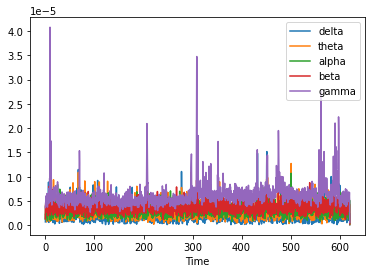

In [28]:
ps.plot_psd_band("C3",logscale=False)

In [29]:
ps.psd_bb_dfs

{'C3':                 delta         theta         alpha          beta         gamma
 0.000    6.951872e-07  1.270475e-06  1.301174e-06  1.358441e-06  3.636831e-06
 0.375    3.977883e-06  4.210818e-06  2.365917e-06  3.729452e-06  4.659337e-06
 0.750    9.881162e-07  1.516793e-06  1.851722e-06  5.094717e-06  4.594220e-06
 1.125    1.016088e-06  1.964192e-06  1.969101e-06  2.774668e-06  6.032432e-06
 1.500    2.119134e-06  1.577078e-06  1.691806e-06  4.544780e-06  5.202051e-06
 ...               ...           ...           ...           ...           ...
 619.125  1.585313e-06  1.421166e-06  1.068256e-06  2.997751e-06  4.917044e-06
 619.500  9.733816e-07  1.497550e-06  2.095252e-06  4.687187e-06  5.894254e-06
 619.875  8.969596e-07  3.395814e-06  3.411764e-06  4.216432e-06  6.776184e-06
 620.250  2.478041e-06  4.321538e-06  5.151593e-06  3.144643e-06  5.153362e-06
 620.625  7.110179e-08  1.467670e-07  2.916549e-07  2.968277e-07  5.422070e-07
 
 [1656 rows x 5 columns],
 'C4':            

# 

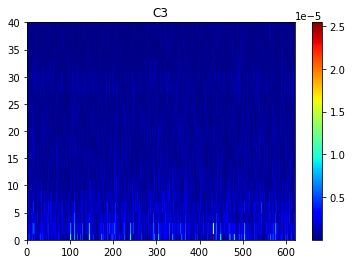

In [30]:
ps.plot_psd("C3",logscale=True)

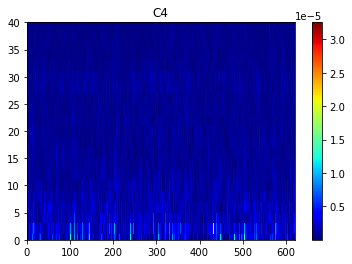

In [31]:
ps.plot_psd("C4",logscale=True)